In [ ]:
# https://stackoverflow.com/questions/48641189/fitting-3d-data-as-input-into-keras-sequential-model-layer

In [ ]:
# !conda install keras=2.3.1 -y

In [ ]:
# To check avialable CPU and GPU
#import tensorflow as tf
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [2]:
 #Use only CPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc

#keras
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle5 as pickle

In [2]:
# small old ../datasets/AMPsNonAMPs_df.239.plk
# /home/ubuntu/data/AMPsNonAMPs_df.plk old dataset
# /mnt/vdb/thesis/jax/AMPNonAMP.final.reps new dataset
with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V5_C08_sim60.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [6]:
# For PWS
with open( '/mnt/vdb/thesis/pwm/AMPnonAMP.sim60_c08.pwm.pkl', 'rb') as file:
    AMPs_df = pickle.load(file)


In [4]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df =AMPs_df[AMPs_df["length"] <=30 ]
AMPs_df 

,ID,length,class,reps
1111,"10015_dbaasp,10016_dbaasp|dbaasp_peptides",11,0,"[0.20464208722114563, -0.055944692343473434, 0..."
973,10026_dbaasp|dbaasp_peptides,22,0,"[0.1005186140537262, 0.0014500601682811975, 0...."
524,10029_dbaasp|dbaasp_peptides,14,0,"[0.14606480300426483, 0.04153195396065712, 0.0..."
1979,"1003,1011,1019,1027,1035|CancerPPD_l_natural",20,0,"[0.02989775501191616, -0.004465686157345772, -..."
1917,10030_dbaasp|dbaasp_peptides,18,0,"[0.11731283366680145, 0.022457238286733627, 0...."
...,...,...,...,...
1609,dbAMP_12148,13,0,"[0.2212764024734497, 0.15402714908123016, 0.12..."
617,dbAMP_12158,17,0,"[0.07279127091169357, 0.05830632895231247, -0...."
1051,dbAMP_12161,16,0,"[0.17415067553520203, 0.11548949033021927, 0.0..."
1821,dbAMP_12203,15,0,"[0.03923531994223595, -0.0253727026283741, -0...."


### Utility function: plot_history, display_model_score

In [5]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Split Train/ Test / Validation set

In [8]:
AMPs_df.shape

(137389, 400)

In [12]:
# For PWM -400 dimension
window_sizes = 20

X = AMPs_df[:,0:window_sizes*20].reshape(len(AMPs_df),1,20,window_sizes)
Y = np.array([0] * 68869 + [1] * 68520)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [4]:
# For jax unirep 
#X= np.array(AMPs_df['reps'].to_list())
#y= np.array(AMPs_df['class'].to_list())
X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()), np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
#del X
#del y

In [22]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  82433
Val size:  27478
Test size:  27478


# Model 4: Deep-AmPEP30 + 

In [ ]:
# 3d dimension
# Batchs, n_timesteps, n_features

# Images 3d dimension
# width , heigth , channel

In [9]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(53214, 1900, 1)
(17739, 1900, 1)
(17739, 1900, 1)


In [ ]:
# original method 
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    conv = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)
    # Flatten NN
    flat = Flatten()(conv)
    
    layer_3 = Dense(128)(flat)
    dropout_3 = Dropout(0.2)(layer_3)
    layer_4 = Dense(10)(dropout_3)
    dropout_4 = Dropout(0.2)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_Modelbaseline()
model.summary()

In [17]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00001)

In [11]:
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/AmPPEP30.1900.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='loss', patience=8, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(X_train, y_train, epochs=100,
                    batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[checkpoint, es,lr_scheduler], verbose=1)

 Learning rate:  0.01
Epoch 1/100
832/832 [==============================] - ETA: 0s - loss: 3.6077 - accuracy: 0.6687
Epoch 00001: loss improved from inf to 3.60769, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 225s 270ms/step - loss: 3.6077 - accuracy: 0.6687 - val_loss: 0.7354 - val_accuracy: 0.5756
 Learning rate:  0.01
Epoch 2/100
832/832 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7826
Epoch 00002: loss improved from 3.60769 to 0.47920, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 222s 267ms/step - loss: 0.4792 - accuracy: 0.7826 - val_loss: 0.4271 - val_accuracy: 0.8109
 Learning rate:  0.01
Epoch 3/100
832/832 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8138
Epoch 00003: loss improved from 0.47920 to 0.42904, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 220s 264ms/step - loss: 0

In [17]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

1663/1663 [==============================] - 63s 38ms/step - loss: 0.2671 - accuracy: 0.8893
Train loss:  0.26714572310447693
Train accuracy:  0.8892960548400879
----------------------------------------------------------------------
555/555 [==============================] - 21s 38ms/step - loss: 0.3079 - accuracy: 0.8721
Val loss:  0.307868629693985
Val accuracy:  0.8721461296081543
----------------------------------------------------------------------
555/555 [==============================] - 21s 38ms/step - loss: 0.3020 - accuracy: 0.8752
Test loss:  0.3020343482494354
Test accuracy:  0.8752466440200806


In [18]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      8928
           1       0.87      0.88      0.87      8811

    accuracy                           0.88     17739
   macro avg       0.88      0.88      0.88     17739
weighted avg       0.88      0.88      0.88     17739



# Model 3: ProtCNN
https://www.biorxiv.org/content/10.1101/626507v3.full

In [6]:
# convert format 
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(82433, 1900, 1)
(27478, 1900, 1)
(27478, 1900, 1)


In [23]:
def residual_block(data, filters, d_rate):
  """
  residual_block consist of two resnet layers
  For dilation_rate  # https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
  
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [31]:
x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
#x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ProtCNN.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 1900, 128)    256         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 1900, 128)    512         conv1d_38[0][0]                  
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 1900, 128)    0           batch_normalization_30[0][0]     
______________________________________________________________________________________

In [ ]:
# good model for detect nonAMP

x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(256, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 256, 2)
res2 = residual_block(res1, 256, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(1211 , activation='relu')(x)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

In [8]:
# model

x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(256, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 256, 2)
res2 = residual_block(res1, 256, 3)

x = MaxPooling1D(3)(res2)
x = BatchNormalization()(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(1211 , activation='relu')(x)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(512 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1900, 256)    512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1900, 256)    1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1900, 256)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 

In [10]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# val_loss
# ProtCNN_256X2_NN1221X4.V2.h5
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/ProtCNN.V5.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# val_accuracy

lr_scheduler = LearningRateScheduler(lr_schedule)

history2 = model_ProtCNN.fit(
    X_train, y_train,
    epochs=100, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, es,lr_scheduler]
    )


 Learning rate:  0.001
Epoch 1/100
644/645 [============================>.] - ETA: 0s - loss: 2.7184 - accuracy: 0.6246
Epoch 00001: loss improved from inf to 2.71835, saving model to /mnt/vdb/thesis/ProtCNN.V5.h5
645/645 [==============================] - 127s 196ms/step - loss: 2.7184 - accuracy: 0.6245 - val_loss: 1.3044 - val_accuracy: 0.7311
 Learning rate:  0.001
Epoch 2/100
644/645 [============================>.] - ETA: 0s - loss: 1.1884 - accuracy: 0.6522
Epoch 00002: loss improved from 2.71835 to 1.18844, saving model to /mnt/vdb/thesis/ProtCNN.V5.h5
645/645 [==============================] - 129s 200ms/step - loss: 1.1884 - accuracy: 0.6522 - val_loss: 0.8606 - val_accuracy: 0.8189
 Learning rate:  0.001
Epoch 3/100
644/645 [============================>.] - ETA: 0s - loss: 0.8685 - accuracy: 0.6792
Epoch 00003: loss improved from 1.18844 to 0.86846, saving model to /mnt/vdb/thesis/ProtCNN.V5.h5
645/645 [==============================] - 129s 200ms/step - loss: 0.8685 - accu

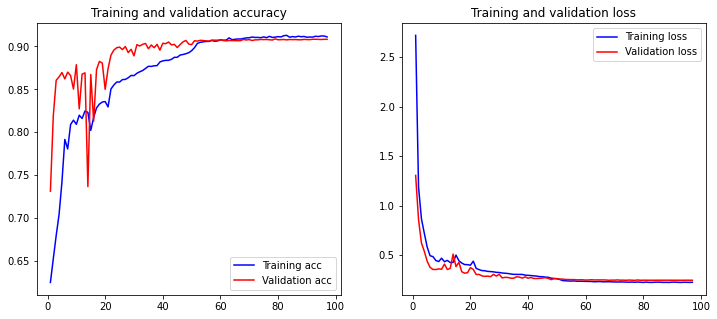

In [11]:
plot_history(history2)

In [13]:
model_ProtCNN.save("/mnt/vdb/thesis/ProtCNN.V5.h5")
#model_ProtCNN= keras.models.load_model("/mnt/vdb/ProtCNN.hdf5")

In [12]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     13856
           1       0.92      0.88      0.90     13622

    accuracy                           0.90     27478
   macro avg       0.91      0.90      0.90     27478
weighted avg       0.91      0.90      0.90     27478



In [19]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     25564
           1       0.94      0.95      0.95     25244

    accuracy                           0.95     50808
   macro avg       0.95      0.95      0.95     50808
weighted avg       0.95      0.95      0.95     50808



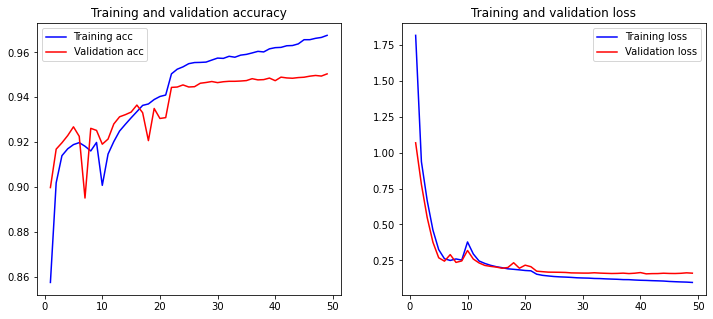

In [20]:
plot_history(history2)

In [3]:
display_model_score(model_ProtCNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

NameError: name 'model_ProtCNN' is not defined

# with PWM

In [ ]:
x_input = Input(shape=(1,20,window_sizes))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
#x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ProtCNN.summary()

# Conclusion

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
with tf.device('/cpu:0'):
        ProtCNN= load_model("/mnt/vdb/ProtCNN.bestmodel.h5")
ProtCNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1900, 256)    512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1900, 256)    1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1900, 256)    0           batch_normalization[0][0]        
_______________________________________________________________________________________